# 1. Overview

The notebook describes a modeling approach for forecasting ASML stock prices, exploring SARIMAX, Prophet, XGBoost, and Random Forest models. Data transformations ensured stationarity, with Prophet achieving the best results using exogenous variables. Models were evaluated based on RMSE and MAPE metrics, and after fine-tuning, Prophet showed significant performance improvement, thus selected as the primary model. The final model parameters were saved for future use, ensuring a robust forecasting framework incorporating market conditions and external factors.

# 2. Forecasting

## 2.1 Import Libraries

In [1]:
# pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
import itertools
import joblib
import json
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Desactivar logs de Prophet
logging.getLogger('cmdstanpy').disabled = True

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global variables

In [3]:
input_data = 'data/weekly_data_combination.csv'
output_model_path = 'models/prophet_asml_combination_with_suppliers.pkl'
output_best_params_path = 'data/best_prophet_params.json'
output_best_variables_path = 'data/best_prophet_variables_with_suppliers.json'
output_regressors_path = 'data/best_regressors.json'
regressors = ['Close_Carl_Zeiss_Meditec', 'Close_Lam_Research_Corporation', 
              'Close_Tokyo_Electron_Limited', 'Close_Taiwan_Semiconductor_Manufacturing_Company',
              'COVID_Period', 'Geopolitical_Tension', 'Trade_Sanctions', 
              'Tech_Regulation', 'New_Product_Launch']
test_weeks = 12

## 2.3 Functions

In [4]:
# Feature engineering for time series
def create_features(df):
    """
    Create time-based features for time series data.
    
    Input:
    - df: DataFrame with a datetime index and a single column for the target variable.

    Output:
    - df: DataFrame with added columns for year, month, week of the year, quarter, and cuatrimestre.

    Logic:
    - Extracts the 'year', 'month', 'week_of_year', 'quarter', and 'cuatrimestre' 
      from the datetime index to create additional time-based features.
    """
    df = df.copy()  # Create a copy of the DataFrame to avoid the warning
    df['year'] = df.index.year            # Extract year from the date
    df['month'] = df.index.month          # Extract month from the date
    df['week_of_year'] = df.index.isocalendar().week  # Extract week of the year from the date
    df['quarter'] = df.index.quarter      # Extract quarter from the date
    df['cuatrimestre'] = ((df.index.month - 1) // 4) + 1  # Calculate cuatrimestre (four-month period)
    return df

## 2.4 Code

Loading the data from notebook 04_data_preparation

In [5]:
weekly_data_combination = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data_combination['Date'] = pd.to_datetime(weekly_data_combination['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data_combination.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data_combination = weekly_data_combination.asfreq('W')


weekly_data_combination.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Taiwan_Semiconductor_Manufacturing_Company,Close_Samsung_Electronics,Close_Intel_Corporation,Weekday,Month,Quarter,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,,,,,,,
2019-01-06,146.401947,75.651291,8.299143,18.953333,30.410763,32299.406250,40.518044,3.0,1.0,1.0,0,0,1,0,0,0
2019-01-13,152.422821,76.849060,8.656210,20.006666,30.967327,34017.457031,41.318424,2.0,1.0,1.0,0,0,1,0,0,0
2019-01-20,149.290100,82.406708,8.441608,21.273333,31.341261,35606.660156,41.714314,2.0,1.0,1.0,0,0,1,0,0,0
2019-01-27,153.062531,82.406708,9.049646,22.076667,32.232623,36723.394531,41.400187,2.0,1.0,1.0,0,0,1,0,0,0
2019-02-03,164.662170,86.019196,10.193889,23.473333,32.558723,39644.078125,40.552475,2.0,1.0,1.0,0,0,1,0,0,0


### 2.4.1 Train test split

We are going to consider *test_weeks* as the number of weeks we want the test to have

In [6]:
train_data = weekly_data_combination[:-test_weeks]
train_data.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Taiwan_Semiconductor_Manufacturing_Company,Close_Samsung_Electronics,Close_Intel_Corporation,Weekday,Month,Quarter,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,,,,,,,
2019-01-06,146.401947,75.651291,8.299143,18.953333,30.410763,32299.406250,40.518044,3.0,1.0,1.0,0,0,1,0,0,0
2019-01-13,152.422821,76.849060,8.656210,20.006666,30.967327,34017.457031,41.318424,2.0,1.0,1.0,0,0,1,0,0,0
2019-01-20,149.290100,82.406708,8.441608,21.273333,31.341261,35606.660156,41.714314,2.0,1.0,1.0,0,0,1,0,0,0
2019-01-27,153.062531,82.406708,9.049646,22.076667,32.232623,36723.394531,41.400187,2.0,1.0,1.0,0,0,1,0,0,0
2019-02-03,164.662170,86.019196,10.193889,23.473333,32.558723,39644.078125,40.552475,2.0,1.0,1.0,0,0,1,0,0,0


In [7]:
test_data = weekly_data_combination[-test_weeks:]
test_data.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Taiwan_Semiconductor_Manufacturing_Company,Close_Samsung_Electronics,Close_Intel_Corporation,Weekday,Month,Quarter,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,,,,,,,
2024-08-25,924.016968,69.900002,83.669449,96.559998,170.809555,77863.117188,20.990000,2.0,8.0,3.0,0,1,1,1,1,1
2024-09-01,886.055847,72.644997,79.407715,89.629997,168.577789,75377.070312,20.129999,2.0,8.0,3.0,0,1,1,1,1,1
2024-09-08,809.584839,66.605000,73.712814,79.215000,160.089119,69609.429688,19.415000,2.0,9.0,3.0,0,1,1,1,1,1
2024-09-15,798.271362,63.835999,72.510414,82.000000,169.604004,65830.632812,19.360001,2.0,9.0,3.0,0,1,1,1,1,1
2024-09-22,801.164551,65.324997,76.603996,83.349998,169.080002,62698.207031,21.139999,2.0,9.0,3.0,0,1,1,1,1,1


Let's visualize what would be the result of the train and test dataframes

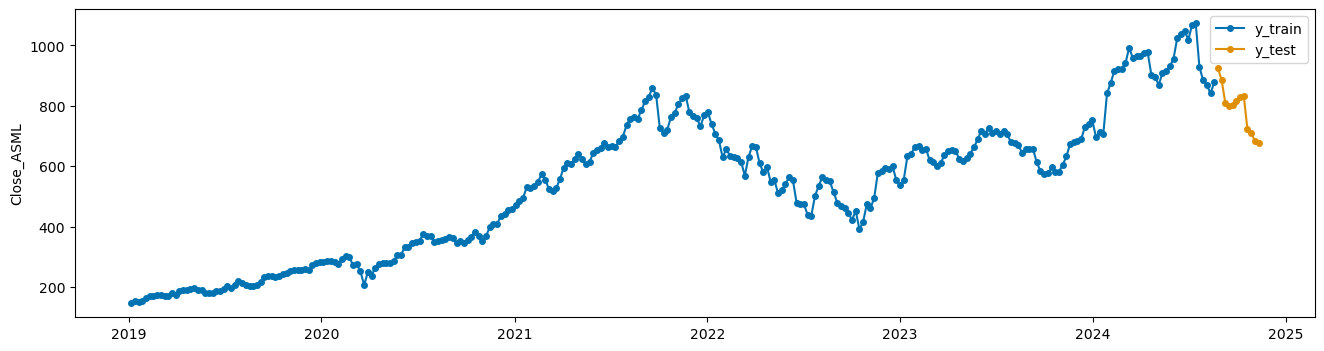

In [8]:
plot_series(train_data['Close_ASML'], test_data['Close_ASML'], labels=["y_train", "y_test"]);

### 2.4.2 SARIMAX

As we saw in notebook 02_forecasting, the series was not stationary, thus we will make the target variable stationary (which is 'Close_ASML') following the same logic that was done in notebook 02_forecasting

Step 1: Log transformation (to stabilize variance)

In [9]:
log_train_data = np.log(train_data['Close_ASML'])

Step 2: Check stationarity using the Augmented Dickey-Fuller test and Differencing if necessary

In [10]:
# Augmented Dickey-Fuller test
result = adfuller(log_train_data, autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("The series is not stationary. Applying differencing.")
    # Differencing to achieve stationarity
    diff_log_train_data = log_train_data.diff().dropna()

    # Check stationarity again after differencing
    result_diff = adfuller(diff_log_train_data, autolag='AIC')
    p_value_diff = result_diff[1]
    print(f'ADF Statistic after differencing: {result_diff[0]}')
    print(f'p-value after differencing: {p_value_diff}')

    if p_value_diff > 0.05:
        print("The series is still not stationary.")
    else:
        print("The series is now stationary with differencing.")
    train_data_stationary = diff_log_train_data
else:
    print("The series is stationary with only log.")
    train_data_stationary = log_train_data

ADF Statistic: -1.8922493746191555
p-value: 0.33571598828083726
The series is not stationary. Applying differencing.
ADF Statistic after differencing: -15.624401355974172
p-value after differencing: 1.715996986083994e-28
The series is now stationary with differencing.


Plot the transformed data to visualize

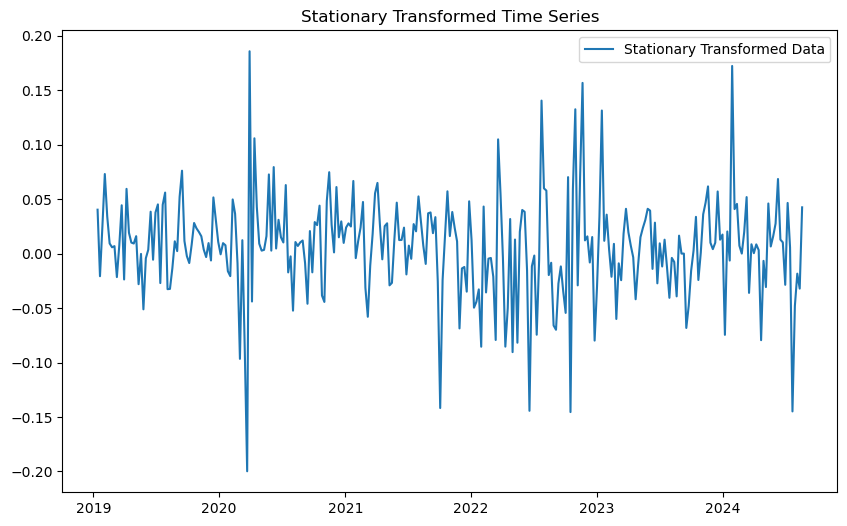

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_data_stationary, label='Stationary Transformed Data')
plt.title('Stationary Transformed Time Series')
plt.legend()
plt.show()

Once we have the stationary series, we initialize the SARIMAX model with the corresponding regressor variables

In [12]:
# Creating the exogenous variables
exog = train_data.drop(['Close_ASML'], axis=1)
# Deleting the first row of exog due to the differentiation
exog = exog[1:]

# Initializing the SARIMAX model
sarima_model = SARIMAX(
    train_data_stationary,     # Training data that is stationary
    exog=exog,                 # Exogenous variables
    order=(1, 1, 1),           # ARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # Seasonal order (P, D, Q, s), here s=52 for weekly data
    enforce_stationarity=False,  # Allow the model to be non-stationary
    enforce_invertibility=False  # Allow the model to be non-invertible
)

In [13]:
# Fit the model to the training data
fitted_sarima = sarima_model.fit(disp=False)

In [14]:
# Generate predictions the future_exog variable
future_exog = test_data.drop('Close_ASML', axis=1)

# Assuming `future_exog` contains the future values of the exogenous variables for the forecast period
y_pred_sarima = fitted_sarima.forecast(steps=len(test_data), exog=future_exog)

Now we have to revert the transformations

In [15]:
# Step 1: Revert the differencing
# 'last_original_value' is the last value before differencing was applied
last_original_value = log_train_data.iloc[-1]

# Add back the last original value to get the cumulative sum and revert differencing
y_pred_sarima_diff_reverted = np.r_[last_original_value, y_pred_sarima].cumsum()

# Remove the first value to match the length of test_data
y_pred_sarima_diff_reverted = y_pred_sarima_diff_reverted[1:]

# Step 2: Revert the logarithmic transformation
y_pred_sarima_reverted = np.exp(y_pred_sarima_diff_reverted)

# Convert the reverted predictions to a pandas Series
y_pred_sarima_reverted = pd.Series(y_pred_sarima_reverted, index=test_data.index)

Let's plot the data and predictions

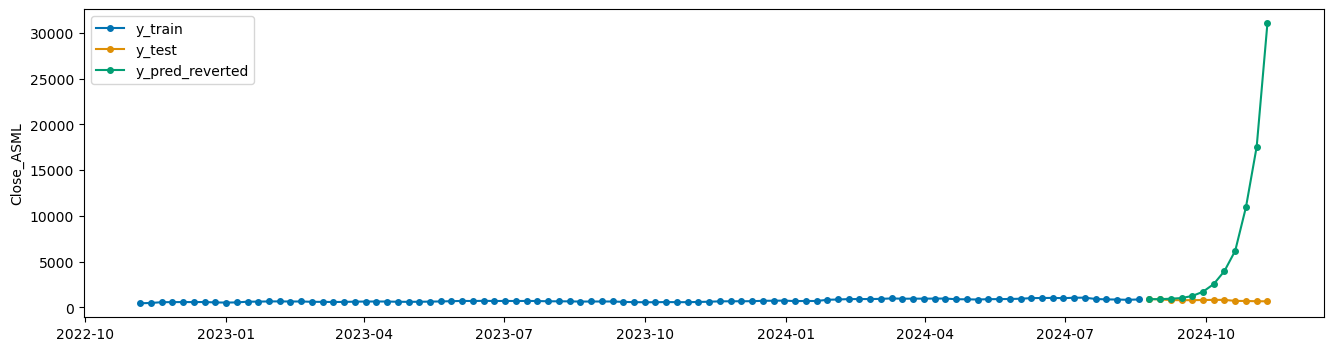

In [16]:
# Plot the training, test data, and predictions
plot_series(train_data['Close_ASML'][200:], test_data['Close_ASML'], y_pred_sarima_reverted, labels=["y_train", "y_test", "y_pred_reverted"]);

In [17]:
# Calculate MAPE for SARIMA model
mape_sarima = mean_absolute_percentage_error(test_data['Close_ASML'], y_pred_sarima_reverted) * 100
mape_sarima

830.9895020587243

In [18]:
# Calculate RMSE for SARIMA model
rmse_sarima = root_mean_squared_error(test_data['Close_ASML'], y_pred_sarima_reverted)
rmse_sarima

10635.342160660173

The results are not good if they're compared with those of notebook 02_forecasting. So, we are disregarding the SARIMAX model for now.

### 2.4.3 Prophet

Initialize the Prophet model

In [19]:
prophet_model = Prophet()

Fit the model to the data

First we need to modify the column names as is required by prophet

In [20]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
train_data_prophet.head()

,ds,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Taiwan_Semiconductor_Manufacturing_Company,Close_Samsung_Electronics,Close_Intel_Corporation,Weekday,Month,Quarter,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
0,2019-01-06,146.401947,75.651291,8.299143,18.953333,30.410763,32299.406250,40.518044,3.0,1.0,1.0,0,0,1,0,0,0
1,2019-01-13,152.422821,76.849060,8.656210,20.006666,30.967327,34017.457031,41.318424,2.0,1.0,1.0,0,0,1,0,0,0
2,2019-01-20,149.290100,82.406708,8.441608,21.273333,31.341261,35606.660156,41.714314,2.0,1.0,1.0,0,0,1,0,0,0
3,2019-01-27,153.062531,82.406708,9.049646,22.076667,32.232623,36723.394531,41.400187,2.0,1.0,1.0,0,0,1,0,0,0
4,2019-02-03,164.662170,86.019196,10.193889,23.473333,32.558723,39644.078125,40.552475,2.0,1.0,1.0,0,0,1,0,0,0


In [21]:
test_data_prophet = test_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
test_data_prophet.head()

,ds,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,Close_Taiwan_Semiconductor_Manufacturing_Company,Close_Samsung_Electronics,Close_Intel_Corporation,Weekday,Month,Quarter,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
0,2024-08-25,924.016968,69.900002,83.669449,96.559998,170.809555,77863.117188,20.990000,2.0,8.0,3.0,0,1,1,1,1,1
1,2024-09-01,886.055847,72.644997,79.407715,89.629997,168.577789,75377.070312,20.129999,2.0,8.0,3.0,0,1,1,1,1,1
2,2024-09-08,809.584839,66.605000,73.712814,79.215000,160.089119,69609.429688,19.415000,2.0,9.0,3.0,0,1,1,1,1,1
3,2024-09-15,798.271362,63.835999,72.510414,82.000000,169.604004,65830.632812,19.360001,2.0,9.0,3.0,0,1,1,1,1,1
4,2024-09-22,801.164551,65.324997,76.603996,83.349998,169.080002,62698.207031,21.139999,2.0,9.0,3.0,0,1,1,1,1,1


Add each regressor to the Prophet model

In [22]:
for regressor in regressors:
    prophet_model.add_regressor(regressor)

Fit the model

In [23]:
prophet_model.fit(train_data_prophet)

In [24]:
# Generate predictions
forecast = prophet_model.predict(test_data_prophet[[column for column in test_data_prophet if column != 'y']])
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,COVID_Period,COVID_Period_lower,COVID_Period_upper,Close_Carl_Zeiss_Meditec,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-08-25,680.439147,873.847465,948.810206,680.439147,680.439147,0.0,0.0,0.0,-107.559160,...,231.653043,231.653043,231.653043,-0.641728,-0.641728,-0.641728,0.0,0.0,0.0,911.450462
1,2024-09-01,682.570522,865.741615,938.747875,682.570522,682.570522,0.0,0.0,0.0,-102.156797,...,217.191483,217.191483,217.191483,1.358203,1.358203,1.358203,0.0,0.0,0.0,901.120208
2,2024-09-08,684.701897,822.545729,891.156743,684.700679,684.730494,0.0,0.0,0.0,-114.043979,...,169.483370,169.483370,169.483370,1.930719,1.930719,1.930719,0.0,0.0,0.0,856.115985
3,2024-09-15,686.833272,826.648082,900.446651,686.806034,686.898339,0.0,0.0,0.0,-119.493587,...,177.980577,177.980577,177.980577,0.065476,0.065476,0.065476,0.0,0.0,0.0,864.879325
4,2024-09-22,688.964647,835.984887,908.040910,688.887306,689.095821,0.0,0.0,0.0,-116.563123,...,191.027971,191.027971,191.027971,-4.928940,-4.928940,-4.928940,0.0,0.0,0.0,875.063677


Plot forecast components (trend, weekly, yearly components)

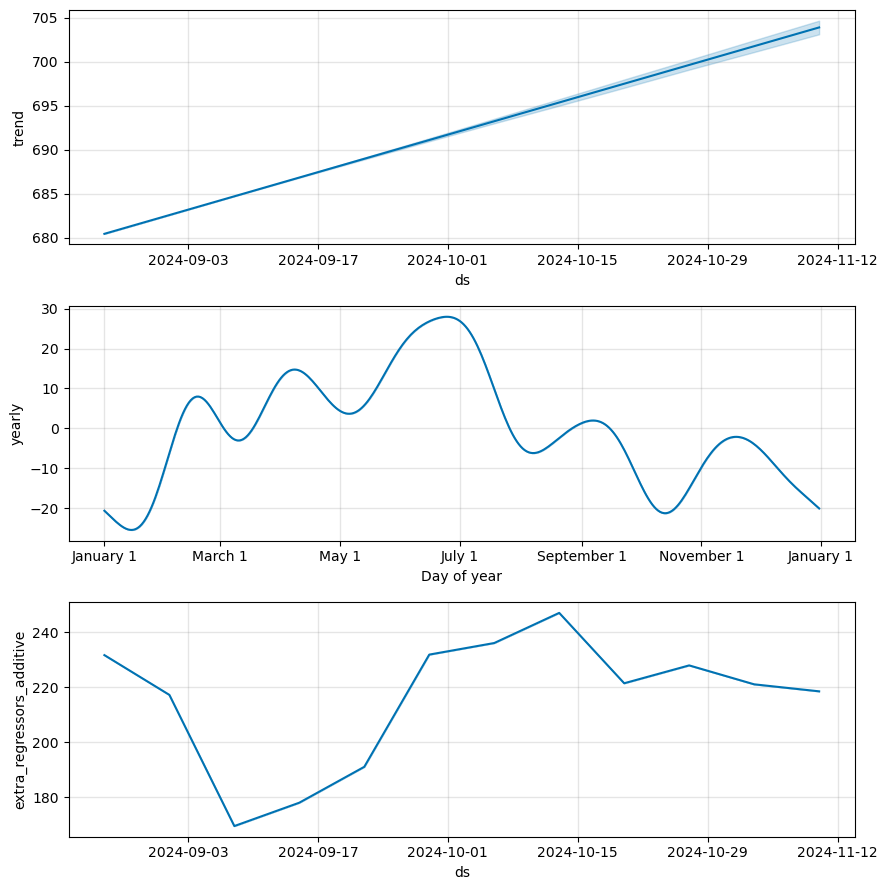

In [25]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

The Prophet model's forecast shows a steady upward trend, indicating growth over time. There is clear yearly seasonality, with peaks around July and dips towards the year's end, suggesting cyclical behavior. An additional regressor also impacts the forecast, introducing periodic fluctuations that align with external factors. Together, these components suggest the forecast is influenced by an overall upward trend, annual cycles, and external variables.

In [26]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

forecast

,Close
ds,
2024-08-25,911.450462
2024-09-01,901.120208
2024-09-08,856.115985
2024-09-15,864.879325
2024-09-22,875.063677
2024-09-29,910.852602
2024-10-06,910.740886
2024-10-13,921.129508
2024-10-20,899.764010


In [27]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Ensure ds is the index of test_data_prophet 
test_data_prophet = test_data_prophet.set_index('ds')

Plot the forecast results

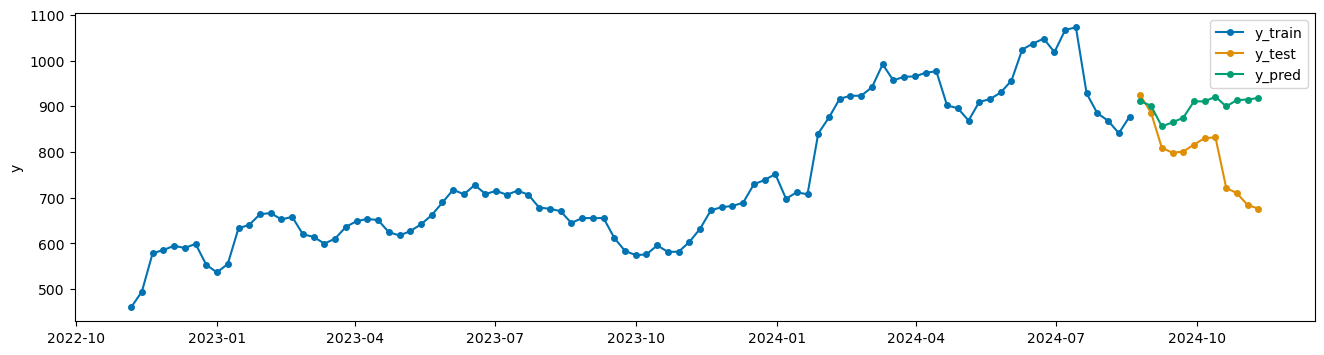

In [28]:
plot_series(train_data_prophet[['y']][200:], test_data_prophet[['y']], forecast, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [29]:
mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast) * 100
mape_prophet

15.105689092731112

In [30]:
rmse_prophet = root_mean_squared_error(test_data_prophet['y'], forecast)
rmse_prophet

135.6838518794445

The results are very positive. So, it's interesting to consider the extra information that the regressors provide. We will still try other models to see their results. All things considered, results seem to be good for now.

### 2.4.6 XGboost

We will try again XGBoost as we did in notebook 02_forecasting and we will do so using the temporal variables using the create_features function.

In [31]:
train_data_xgb_rf = create_features(train_data)
test_data_xgb_rf = create_features(test_data)

In [32]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_xgb = train_data_xgb_rf.drop('Close_ASML', axis=1)
y_train_xgb = train_data_xgb_rf['Close_ASML']
X_test_xgb = test_data_xgb_rf.drop('Close_ASML', axis=1)
y_test_xgb = test_data_xgb_rf['Close_ASML']

In [33]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [34]:
# Train the model
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [35]:
# Generate predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb = pd.DataFrame(y_pred_xgb, index=test_data.index, columns=['Close_ASML'])

In [36]:
# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb

88.25214137828009

In [37]:
mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)*100
mape_xgb

9.794709776849949

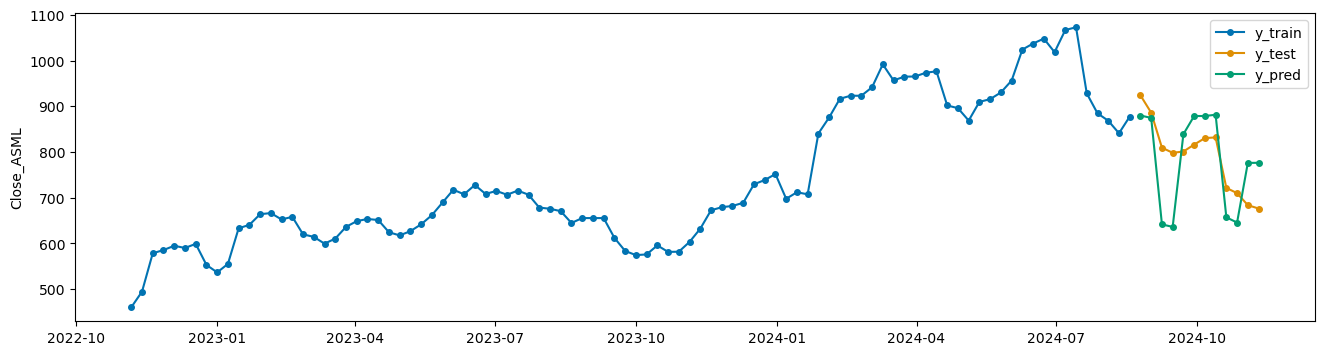

In [38]:
# Plot actual vs. predicted values
plot_series(y_train_xgb[200:], y_test_xgb, y_pred_xgb, labels=["y_train", "y_test", "y_pred"]);

Results if compared with the previous prophet models are not so good in a numerical and visual sense and so, we will still choose the prophet as our main model.

### 2.4.7 Random Forest

We will proceed with the Random Forest model using the same logic that we used for XGBoost.

In [39]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_rf = train_data_xgb_rf.drop('Close_ASML', axis=1)
y_train_rf = train_data_xgb_rf['Close_ASML']
X_test_rf = test_data_xgb_rf.drop('Close_ASML', axis=1)
y_test_rf = test_data_xgb_rf['Close_ASML']

In [40]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [41]:
# Train the model
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, random_state=42)

In [42]:
# Generate predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Convert predictions to a DataFrame with the same index as the test data
y_pred_rf = pd.DataFrame(y_pred_rf, index=test_data.index, columns=['Close'])

In [43]:
# Evaluate the model's performance
rmse_rf = root_mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf

96.39489893792366

In [44]:
mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf)*100
mape_rf

10.712632906998147

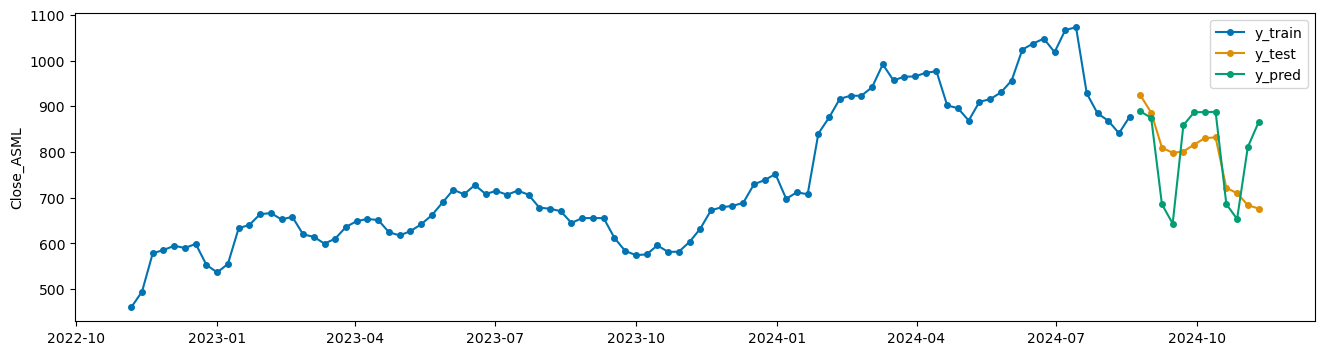

In [45]:
# Plot actual vs. predicted values
plot_series(y_train_rf[200:], y_test_rf, y_pred_rf, labels=["y_train", "y_test", "y_pred"]);

The results are far from convincing. So, we decide to keep with the prophet model. Nevertheless, we will create a table that compares the MAPE and RMSE results of all the models in the following code cells.

### 2.4.8 RMSE and MAPE comparison

In [46]:
# Create a dictionary to store RMSE and MAPE for each model
metrics = {
    "Model": ["SARIMAX", "Prophet", "XGBoost", "Random Forest"],
    "RMSE": [
        rmse_sarima,
        rmse_prophet,
        rmse_xgb,
        rmse_rf
    ],
    "MAPE": [
        mape_sarima,
        mape_prophet,
        mape_xgb,
        mape_rf
    ]
}

In [47]:
# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,RMSE,MAPE
0,SARIMAX,10635.342161,830.989502
1,Prophet,135.683852,15.105689
2,XGBoost,88.252141,9.794710
3,Random Forest,96.394899,10.712633


Our best model is Prophet as it has the lowest RMSE and MAPE. We shall now proceed to do a fine-tunning of the prophet model. We will be disregarding the other models because they are significantly worse in performance.

### 2.4.9 Checking for the best regressors

Let's define the new parameters in the regressor dictionary that interests us

In [48]:
# Extracting the coefficients of the regressors from a trained Prophet model
# Ensure the prophet_model has been trained with regressors

# The model's trained parameters are stored in prophet_model.params
model_params = prophet_model.params

# Access the dataframe containing the coefficients for extra regressors
# 'beta' contains the coefficients for additional regressors
regressor_coefficients = model_params['beta'][0]

# Extract the names of the regressors
# These are stored in the model's 'extra_regressors' attribute
regressor_names = list(prophet_model.extra_regressors.keys())

# Combine the regressor names with their corresponding coefficients
# This creates a dictionary where the keys are regressor names and values are coefficients
regressor_coefficients_dict = dict(zip(regressor_names, regressor_coefficients))

# Find the top 5 regressors with the highest coefficients (absolute values)
# Sort the dictionary by absolute values of the coefficients in descending order
new_regressors = sorted(regressor_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

# Convert the top 5 regressors into a list of tuples
new_regressors_list = [regressor for regressor, coefficient in new_regressors]

# Print the top 5 regressors with the highest coefficients
print("\nTop 5 Regressors with Highest Coefficients:")
for regressor in new_regressors_list:
    print(f"{regressor}")



Top 5 Regressors with Highest Coefficients:
Close_Lam_Research_Corporation
Close_Carl_Zeiss_Meditec
Trade_Sanctions
Geopolitical_Tension
Close_Tokyo_Electron_Limited


Let's keep these top 5 regressors in the train_data_prophet and test_data_prophet

In [50]:
train_data_prophet = train_data_prophet[['y'] + new_regressors_list]
train_data_prophet

,y,Close_Lam_Research_Corporation,Close_Carl_Zeiss_Meditec,Trade_Sanctions,Geopolitical_Tension,Close_Tokyo_Electron_Limited
ds,,,,,,
2019-01-06,146.401947,8.299143,75.651291,1,0,18.953333
2019-01-13,152.422821,8.656210,76.849060,1,0,20.006666
2019-01-20,149.290100,8.441608,82.406708,1,0,21.273333
2019-01-27,153.062531,9.049646,82.406708,1,0,22.076667
2019-02-03,164.662170,10.193889,86.019196,1,0,23.473333
...,...,...,...,...,...,...
2024-07-21,928.163513,93.833580,67.750000,1,1,100.919998
2024-07-28,884.676086,88.227890,66.550003,1,1,94.610001
2024-08-04,868.516907,82.893707,68.070000,1,1,92.120003


In [52]:
test_data_prophet = test_data_prophet[['y'] + new_regressors_list]
test_data_prophet

,y,Close_Lam_Research_Corporation,Close_Carl_Zeiss_Meditec,Trade_Sanctions,Geopolitical_Tension,Close_Tokyo_Electron_Limited
2024-08-25,924.016968,83.669449,69.900002,1,1,96.559998
2024-09-01,886.055847,79.407715,72.644997,1,1,89.629997
2024-09-08,809.584839,73.712814,66.605000,1,1,79.215000
2024-09-15,798.271362,72.510414,63.835999,1,1,82.000000
2024-09-22,801.164551,76.603996,65.324997,1,1,83.349998
2024-09-29,816.269165,80.375000,70.800003,1,1,85.470001
2024-10-06,830.465942,81.408997,74.760002,1,1,88.830002
2024-10-13,832.022278,82.059998,72.779999,1,1,86.790001
2024-10-20,721.570862,74.139999,67.094002,1,1,81.540001
2024-10-27,710.037903,73.000000,67.529999,1,1,76.709999


### 2.4.10 Fine-tunning

We will first run a code using a gridsearch to gain an understanding of the approximate locations of the global minimal for each company

In [ ]:
# Dictionary to store the best parameters, MAPE, and RMSE for each company
best_params_per_company = {}
final_mape_per_company = {}
final_rmse_per_company = {}
company_params = {}

# Define grid ranges
changepoint_range = [round(x, 3) for x in np.arange(0.001, 1.001, 0.1)]
seasonality_range = [round(x, 2) for x in np.arange(0.01, 10.1, 1)]
seasonality_modes = ['multiplicative']
weekly_seasonality_options = [True, False]
yearly_seasonality_options = [True, False]
daily_seasonality_options = [True, False]

# Calculate total combinations for a single company
total_combinations_per_company = (
    len(changepoint_range) *
    len(seasonality_range) *
    len(seasonality_modes) *
    len(weekly_seasonality_options) *
    len(yearly_seasonality_options) *
    len(daily_seasonality_options)
)

# Loop through each company in company_tickers
for ticker, company in company_tickers.items():
    print(f"Optimizing for {company}...")
    print(f"Total combinations to test: {total_combinations_per_company}")

    # Prepare training and test data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure the index is of datetime type
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)

    # Initialize variables to track the best parameters
    best_mape = float('inf')
    best_rmse = float('inf')
    best_params = None
    best_forecast = None

    # Perform grid search
    for changepoint_prior_scale in changepoint_range:
        for seasonality_prior_scale in seasonality_range:
            for seasonality_mode in seasonality_modes:
                for weekly_seasonality in weekly_seasonality_options:
                    for yearly_seasonality in yearly_seasonality_options:
                        for daily_seasonality in daily_seasonality_options:
                            try:
                                # Train the Prophet model
                                model = Prophet(
                                    changepoint_prior_scale=changepoint_prior_scale,
                                    seasonality_prior_scale=seasonality_prior_scale,
                                    seasonality_mode=seasonality_mode,
                                    weekly_seasonality=weekly_seasonality,
                                    yearly_seasonality=yearly_seasonality,
                                    daily_seasonality=daily_seasonality
                                )
                                model.fit(train_data_prophet)

                                # Make predictions
                                future = model.make_future_dataframe(periods=test_weeks, freq='W')
                                forecast = model.predict(future)
                                forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

                                # Calculate MAPE
                                actuals = test_data['Close']
                                predictions = forecast_filtered['Close']
                                common_index = actuals.index.intersection(predictions.index)
                                mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

                                # Calculate RMSE
                                actuals = actuals.loc[common_index]
                                predictions = predictions.loc[common_index]
                                rmse = root_mean_squared_error(actuals, predictions)

                                # Update the best parameters if the current MAPE is lower
                                if mape < best_mape:
                                    best_mape = mape
                                    best_rmse = rmse
                                    best_params = {
                                        'changepoint_prior_scale': changepoint_prior_scale,
                                        'seasonality_prior_scale': seasonality_prior_scale,
                                        'seasonality_mode': seasonality_mode,
                                        'weekly_seasonality': weekly_seasonality,
                                        'yearly_seasonality': yearly_seasonality,
                                        'daily_seasonality': daily_seasonality
                                    }
                                    best_forecast = forecast_filtered

                            except Exception as e:
                                print(f"\nError with parameters: changepoint_prior_scale={changepoint_prior_scale}, "
                                      f"seasonality_prior_scale={seasonality_prior_scale}, "
                                      f"seasonality_mode={seasonality_mode}, "
                                      f"weekly_seasonality={weekly_seasonality}, "
                                      f"yearly_seasonality={yearly_seasonality}, "
                                      f"daily_seasonality={daily_seasonality}: {e}")

    # Save the best parameters and performance metrics
    best_params_per_company[company] = best_params
    final_mape_per_company[company] = best_mape
    final_rmse_per_company[company] = best_rmse
    company_params[company] = best_params

    # Print the best parameters, MAPE, and RMSE for the company
    print(f"\nForecasting for {company}:")
    print(f"Best parameters: {best_params}")
    print(f"MAPE: {best_mape:.2f}")
    print(f"RMSE: {best_rmse:.2f}")

    # Plot the forecast results for the company
    plot_series(
        train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
        test_data['Close'],
        best_forecast['Close'],
        labels=["y_train", "y_test", "y_pred"]
    )
    plt.title(f"Forecasting for {company}")
    plt.show()

Now let's run a specific param_grid for each of the companies

In [48]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_params
for company, params in company_params.items():
    print(f"\nProcessing company: {company}...\n")

    # Retrieve parameter ranges for the current company
    param_ranges = {
        'changepoint_prior_scale': np.round(np.linspace(
            params['changepoint_prior_scale'] / 2,
            params['changepoint_prior_scale'] * 2,
            10), 5),
        'seasonality_prior_scale': np.round(np.linspace(
            params['seasonality_prior_scale'] / 2,
            params['seasonality_prior_scale'] * 2,
            10), 5),
        'seasonality_mode': ['multiplicative'],
        'weekly_seasonality': [True, False],
        'yearly_seasonality': [True, False],
        'daily_seasonality': [True, False]
    }

    # Generate all parameter combinations
    param_combinations = list(product(
        param_ranges['changepoint_prior_scale'],
        param_ranges['seasonality_prior_scale'],
        param_ranges['seasonality_mode'],
        param_ranges['weekly_seasonality'],
        param_ranges['yearly_seasonality'],
        param_ranges['daily_seasonality']
    ))

    total_combinations = len(param_combinations)
    print(f"Total combinations to test for {company}: {total_combinations}")

    # Prepare data
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)

    # Initialize variables to track the best parameters
    best_mape = float('inf')
    best_rmse = float('inf')
    best_params = None

    # Iterate over all parameter combinations
    for combination in param_combinations:
        (changepoint_prior_scale,
         seasonality_prior_scale,
         seasonality_mode,
         weekly_seasonality,
         yearly_seasonality,
         daily_seasonality) = combination

        try:
            # Fit the Prophet model with the current parameter combination
            model = Prophet(
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                seasonality_mode=seasonality_mode,
                weekly_seasonality=weekly_seasonality,
                yearly_seasonality=yearly_seasonality,
                daily_seasonality=daily_seasonality
            )
            model.fit(train_data_prophet)

            # Make predictions
            future = model.make_future_dataframe(periods=test_weeks, freq='W')
            forecast = model.predict(future)
            forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

            # Calculate MAPE and RMSE
            actuals = test_data['Close']
            predictions = forecast_filtered['Close']
            common_index = actuals.index.intersection(predictions.index)
            actuals = actuals.loc[common_index]
            predictions = predictions.loc[common_index]

            mape = mean_absolute_percentage_error(actuals, predictions) * 100
            rmse = root_mean_squared_error(actuals, predictions)

            # Update the best parameters if the current MAPE is lower
            if mape < best_mape:
                best_mape = mape
                best_rmse = rmse
                best_params = {
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'seasonality_prior_scale': seasonality_prior_scale,
                    'seasonality_mode': seasonality_mode,
                    'weekly_seasonality': weekly_seasonality,
                    'yearly_seasonality': yearly_seasonality,
                    'daily_seasonality': daily_seasonality
                }
        except Exception as e:
            print(f"Error with parameters: {combination}: {e}")

    # Print the best parameters, MAPE, and RMSE for the current company
    print(f"\nBest parameters for {company}: {best_params}")
    print(f"MAPE: {best_mape:.2f}")
    print(f"RMSE: {best_rmse:.2f}")

    # Plot the forecast results for the best parameters
    model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )
    model.fit(train_data_prophet)

    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    plot_series(
        train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
        test_data['Close'],
        forecast_filtered['Close'],
        labels=["y_train", "y_test", "y_pred"]
    )
    plt.title(f"Forecasting for {company}")
    plt.show()

    # Fit the Prophet model with all data (train and test) for final storage
    prophet_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )

    # Prepare combined data for final model training
    test_data = pd.DataFrame(actuals).rename(columns={'Close': 'y'}).reset_index(names="ds")
    all_data = pd.concat([train_data_prophet, test_data])
    prophet_model.fit(all_data)

    # Store the model in the dictionary with the company name as key
    prophet_models[company] = prophet_model



Best parameters: {'changepoint_prior_scale': 1.0, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.9, 'weekly_seasonality': False, 'yearly_seasonality': True} with MAPE: 6.05% and RMSE: 53.76


Let's now do again the prophet model with the best parameters

Initialize the Prophet model

In [49]:
prophet_model_best = Prophet(
                changepoint_prior_scale=best_params['changepoint_prior_scale'],
                daily_seasonality=best_params['daily_seasonality'],
                seasonality_mode=best_params['seasonality_mode'],
                seasonality_prior_scale=best_params['seasonality_prior_scale'],
                weekly_seasonality=best_params['weekly_seasonality'],
                yearly_seasonality=best_params['yearly_seasonality']
            )

Fit the model to the data

First we need to modify the column names as is required by prophet

In [50]:
# For train
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})

# For test
test_data_prophet = test_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})

Adding the regressors

In [51]:
for regressor in regressors:
    prophet_model_best.add_regressor(regressor)

Doing the fit of the model

In [52]:
prophet_model_best.fit(train_data_prophet)

In [53]:
# Generate predictions
forecast_best = prophet_model_best.predict(test_data_prophet[[column for column in test_data_prophet if column != 'y']])

Plot forecast components (trend, weekly, yearly components)

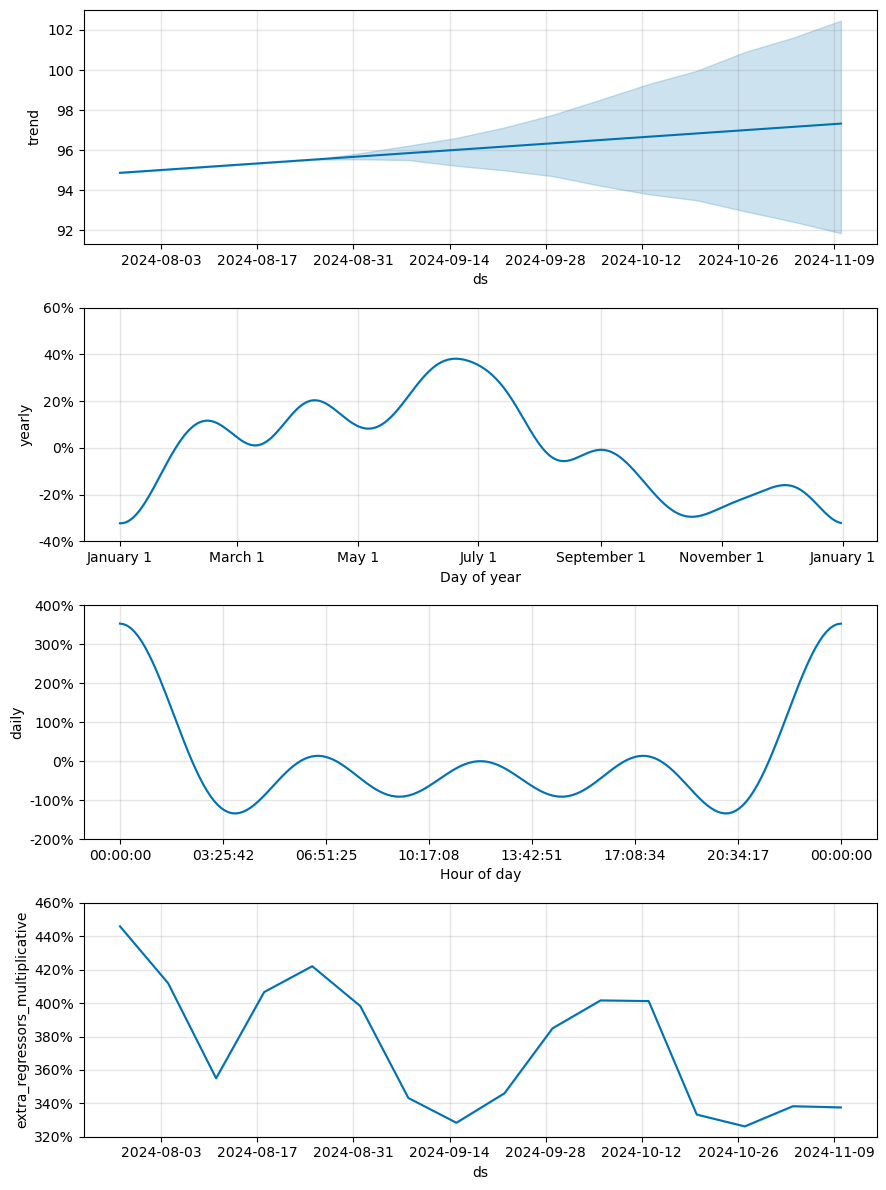

In [54]:
fig2 = prophet_model_best.plot_components(forecast_best)
plt.show()

In [55]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_best = forecast_best[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

forecast_best

,Close
ds,
2024-07-28,858.470255
2024-08-04,820.061768
2024-08-11,763.829810
2024-08-18,815.142509
2024-08-25,833.807220
2024-09-01,813.634639
2024-09-08,760.493145
2024-09-15,742.849687
2024-09-22,754.704822


In [56]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Ensure ds is the index of test_data_prophet 
test_data_prophet = test_data_prophet.set_index('ds')

Plot the forecast results

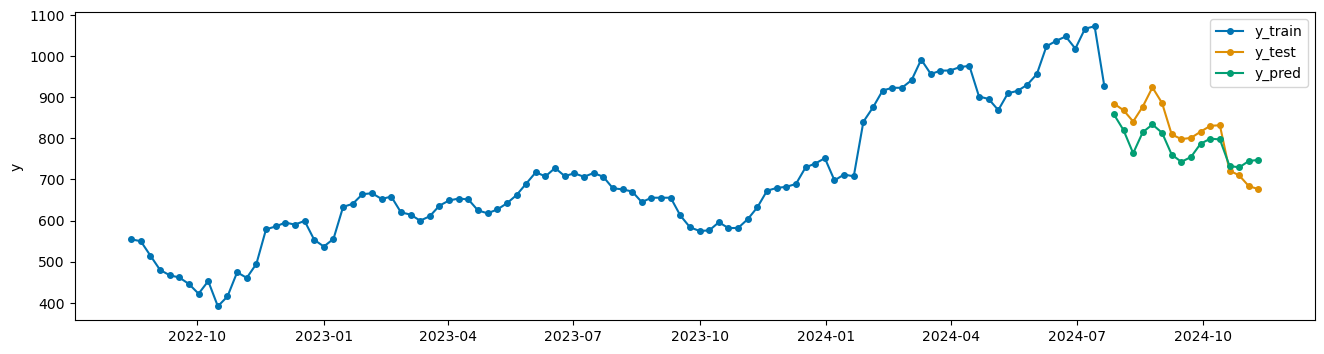

In [57]:
plot_series(train_data_prophet['y'][500:], test_data_prophet['y'], forecast_best, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [58]:
mape_prophet_best = mean_absolute_percentage_error(test_data_prophet['y'], forecast_best) * 100

mape_prophet_best

6.051886314536013

In [59]:
rmse_prophet_best = root_mean_squared_error(test_data_prophet['y'], forecast_best)
rmse_prophet_best

53.75808368591861

As can be seen, the prophet RMSE and MAPE results improve with the fine-tunning

#### 2.4.10.1 Results

The final fine-tune prophet model improved the MAPE and the RMSE results with respect to the non-fine tunned prophet model

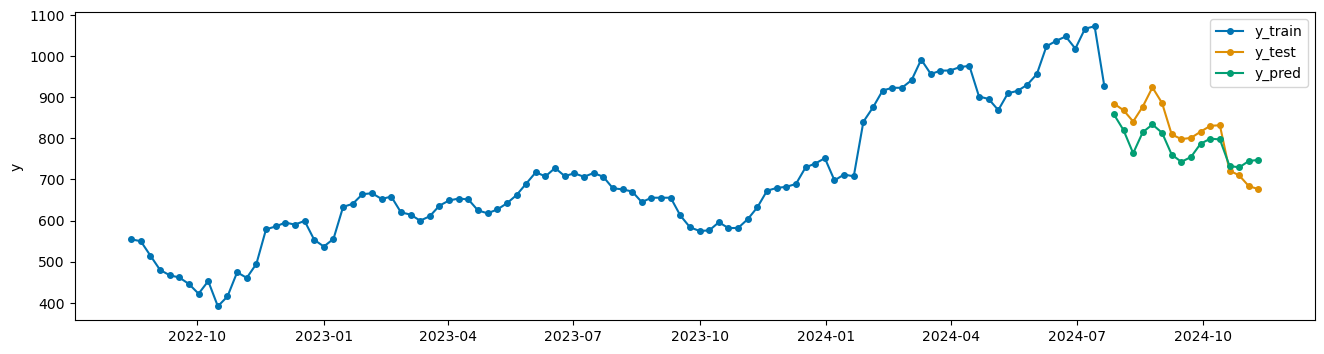

In [60]:
plot_series(train_data_prophet['y'][500:], test_data_prophet['y'], forecast_best, labels=["y_train", "y_test", "y_pred"]);

#### 2.4.10.2 Save the best model and best rmse and MAPE

Saving the rmse_prophet_best and rmse_prophet_best variables

In [61]:
# Variable definition
best_prophet_variables_with_suppliers = {"rmse_prophet_best_with_suppliers": rmse_prophet_best, 
                                         "mape_prophet_best_with_suppliers": mape_prophet_best}

# Save the variable to a JSON file
with open(output_best_variables_path, 'w') as file:
    json.dump(best_prophet_variables_with_suppliers, file)

Saving the top five regressors

In [54]:
new_regressors = {'chosen_regressors':new_regressors_list}

# Save the variable to a JSON file
with open(output_regressors_path, 'w') as file:
    json.dump(new_regressors, file)

{'regressors': ['Close_Lam_Research_Corporation',
  'Close_Carl_Zeiss_Meditec',
  'Trade_Sanctions',
  'Geopolitical_Tension',
  'Close_Tokyo_Electron_Limited']}

Saving the best model

In [62]:
# Saving the best model
joblib.dump(prophet_model_best, output_model_path)

# Save the best parameters to a JSON file
with open(output_best_params_path, 'w') as file:
    json.dump(best_params, file, indent=4)